In [ ]:
pip install scikit-fuzzy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 14.8 MB/s eta 0:00:00


In [ ]:
pip install paho-mqtt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.2/67.2 kB 1.8 MB/s eta 0:00:00


/tmp/ipython-input-3616887862.py:8: DeprecationWarning: Callback API version 1 is deprecated, update to latest version
  client = mqtt.Client()


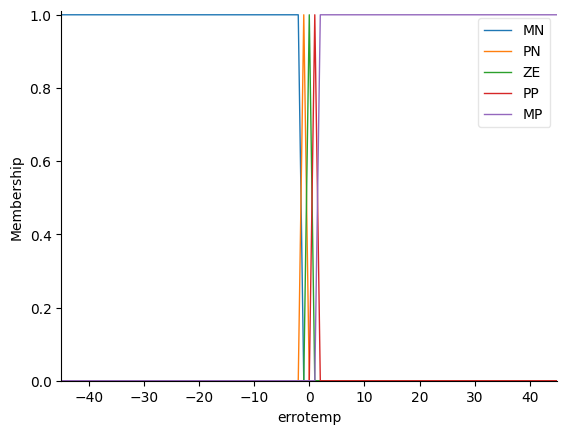

In [ ]:
import numpy as np
import skfuzzy as fuzz
import paho.mqtt.client as mqtt
from skfuzzy import control as ctrl
import time

mqttBroker ="test.mosquitto.org"
client = mqtt.Client()
client.connect(mqttBroker)

# New Antecedent/Consequent objects hold universe variables and membership
# functions
errotemp = ctrl.Antecedent(np.arange(-a, b, c), 'errotemp')
varerrotemp =ctrl.Antecedent(np.arange(-d, e, f), 'varerrotemp')
aquecedor =ctrl.Consequent(np.arange(g, h, i), 'aquecedor')


# Custom membership functions can be built interactively with a familiar,
# Pythonic API
errotemp['MN'] = fuzz.trapmf(errotemp.universe, [-a, -a, -2,-1])
errotemp['PN'] = fuzz.trimf(errotemp.universe, [-2,-1,0])
errotemp['ZE'] = fuzz.trimf(errotemp.universe, [-1, 0, 1])
errotemp['PP'] = fuzz.trimf(errotemp.universe, [0, 1, 2])
errotemp['MP'] = fuzz.trapmf(errotemp.universe,[1, 2, b,b])
# You can see how these look with .view()
errotemp.view()

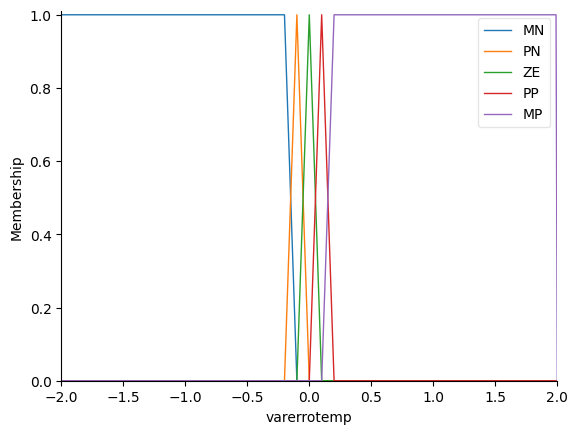

In [ ]:
varerrotemp['MN'] = fuzz.trapmf(varerrotemp.universe, [-d, -d, -0.2,-0.1])
varerrotemp['PN'] = fuzz.trimf(varerrotemp.universe, [-0.2,-0.1,0])
varerrotemp['ZE'] = fuzz.trimf(varerrotemp.universe, [-0.1, 0, 0.1])
varerrotemp['PP'] = fuzz.trimf(varerrotemp.universe, [0, 0.1, 0.2])
varerrotemp['MP'] = fuzz.trapmf(varerrotemp.universe,[0.1, 0.2, e,e])
# You can see how these look with .view()
varerrotemp.view()

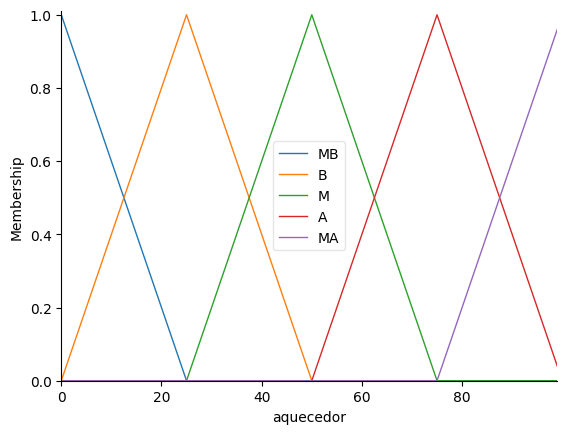

In [ ]:
aquecedor['MB'] = fuzz.trimf(aquecedor.universe, [0,0,g])
aquecedor['B'] = fuzz.trimf(aquecedor.universe, [0,g,h])
aquecedor['M'] = fuzz.trimf(aquecedor.universe, [h, i, 75])
aquecedor['A'] = fuzz.trimf(aquecedor.universe, [h, i, 100])
aquecedor['MA'] = fuzz.trimf(aquecedor.universe, [i, 100, 100])
aquecedor.view()

In [ ]:
regra1 = ctrl.Rule(errotemp['MN']& varerrotemp['MN'], aquecedor['M'])
regra2 = ctrl.Rule(errotemp['PN']& varerrotemp['MN'], aquecedor['M'])
regra3 = ctrl.Rule(errotemp['ZE']& varerrotemp['MN'], aquecedor['M'])
regra4 = ctrl.Rule(errotemp['PP']& varerrotemp['MN'], aquecedor['M'])
regra5 = ctrl.Rule(errotemp['MP']& varerrotemp['MN'], aquecedor['M'])
regra6 = ctrl.Rule(errotemp['MN']& varerrotemp['PN'], aquecedor['M'])
regra7 = ctrl.Rule(errotemp['PN']& varerrotemp['PN'], aquecedor['M'])
regra8 = ctrl.Rule(errotemp['ZE']& varerrotemp['PN'], aquecedor['M'])
regra9 = ctrl.Rule(errotemp['PP']& varerrotemp['PN'], aquecedor['M'])
regra10 = ctrl.Rule(errotemp['MP']& varerrotemp['PN'], aquecedor['M'])
regra11 = ctrl.Rule(errotemp['MN']& varerrotemp['ZE'], aquecedor['M'])
regra12 = ctrl.Rule(errotemp['PN']& varerrotemp['ZE'], aquecedor['M'])
regra13 = ctrl.Rule(errotemp['ZE']& varerrotemp['ZE'], aquecedor['M'])
regra14 = ctrl.Rule(errotemp['PP']& varerrotemp['ZE'], aquecedor['M'])
regra15 = ctrl.Rule(errotemp['MP']& varerrotemp['ZE'], aquecedor['M'])
regra16 = ctrl.Rule(errotemp['MN']& varerrotemp['PP'], aquecedor['M'])
regra17 = ctrl.Rule(errotemp['PN']& varerrotemp['PP'], aquecedor['M'])
regra18 = ctrl.Rule(errotemp['ZE']& varerrotemp['PP'], aquecedor['M'])
regra19 = ctrl.Rule(errotemp['PP']& varerrotemp['PP'], aquecedor['M'])
regra20 = ctrl.Rule(errotemp['MP']& varerrotemp['PP'], aquecedor['M'])
regra21 = ctrl.Rule(errotemp['MN']& varerrotemp['MP'], aquecedor['M'])
regra22 = ctrl.Rule(errotemp['PN']& varerrotemp['MP'], aquecedor['M'])
regra23 = ctrl.Rule(errotemp['ZE']& varerrotemp['MP'], aquecedor['M'])
regra24 = ctrl.Rule(errotemp['PP']& varerrotemp['MP'], aquecedor['M'])
regra25 = ctrl.Rule(errotemp['MP']& varerrotemp['MP'], aquecedor['M'])

In [ ]:
aquecedor_ctrl = ctrl.ControlSystem([regra1, regra2, regra3,regra4,regra5,regra6, regra7, regra8,regra9,regra10,regra11, regra12, regra13,regra14,regra15,regra16, regra17, regra18,regra19,regra20,regra21, regra22, regra23,regra24,regra25])
potencia = ctrl.ControlSystemSimulation(aquecedor_ctrl)

In [ ]:
sp=35
tempatual=18
print(tempatual)
erroatual=-17
while True:
  erroanterior=erroatual
  erroatual=tempatual-sp
  varerroTemp=erroatual-erroanterior
  potencia.input['errotemp'] =erroatual
  potencia.input['varerrotemp'] =varerroTemp
  potencia.compute()
  i=0
  while (i < 10):
    tempatual=tempatual * 0.9954 + potencia.output['aquecedor'] * 0.001963
    time.sleep(0.1)
    i += 1
  print(tempatual)
  client.publish("Aquecedor/Temperatura", tempatual)
  client.publish("Aquecedor/erro", erroatual)

18
18.938733960045056
19.046796398110008
19.57764275471394
19.656916354263302
20.21925990305115
20.26962262732936
20.845201790723586
20.86735995736429
21.509160441781543
21.50140103873807
22.282137002153267
22.23954774928058
22.96952109889269
22.895958740117656
23.60727248361063
23.504973438502685
24.195656671000943
24.066845395200207
24.724046002457126
24.57142582738379
25.192421102716068
25.018696232827768
25.634449811378943
25.44080739892567
26.044172588983987
25.83206831940955
26.41789408352437
26.188950152568054
26.758695040116955
26.514394827032152
27.069475377108972
26.811171592606563
27.352879563607004
27.081805760241465
27.611319121598314
27.328600190222122
27.84699314589581
27.55365488749762
28.061907016513253
27.75888487088798
28.25788946269692
27.946036468220992
28.43660812381351
28.116702176056084
28.599583739503974
28.272334210438476
28.74820308984903
28.414256863988825
28.883730795655893
28.543677774476198
29.00732007927625
28.66169820076027
29.120022577520853
28.7693223